# Gesture Detection Model with interpolated data

## 1 Feature engineering

### 1.1 Import libraries and transformers  

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from keras.utils import to_categorical
warnings.filterwarnings("ignore")

/Users/lsafari/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
os.getcwd()

'/Users/lsafari/drone_steering/models/playground'

In [3]:
os.chdir('../..')

In [22]:
from app_local.module import DataEnsembler, LabelGenerator, GestureTransformer, DataResampler

### 1.2  Load data

In [9]:
de = DataEnsembler(ms_per_frame=120)
de.investigate_available_datafiles(data_dir='data/gesture/', is_frame_based = True)
combined_data_files_df=de.combined_data_files_df
combined_data_files_df

,filename_features,filename_labels
0,features_left_c_02_120.csv,labels_left_c_02.csv
1,features_left_l_01_120.csv,labels_left_l_01.csv
2,features_move_p_01_120.csv,labels_move_p_01.csv
3,features_move_c_01_120.csv,labels_move_c_01.csv
4,features_land_l_03_120.csv,labels_land_l_03.csv
5,features_land_c_01_120.csv,labels_land_c_01.csv
6,features_land_l_02_120.csv,labels_land_l_02.csv
7,features_left_c_03_120.csv,labels_left_c_03.csv
8,features_right_c_02_120.csv,labels_right_c_02.csv
9,features_right_l_01_120.csv,labels_right_l_01.csv


In [10]:
de.load_data()
orig_data = de.data
orig_data

[     leftElbow_x  leftElbow_y   leftHip_x   leftHip_y  leftShoulder_x  \
 0     339.645417   203.705534  330.407067  258.037608      333.380549   
 1     337.786904   205.850688  327.399147  258.864759      330.848589   
 2     338.685882   206.986778  324.564567  258.101021      328.558816   
 3     333.988439   203.014023  325.005074  255.324383      324.594274   
 4     331.709428   201.457220  321.863894  258.354153      323.063889   
 5     333.708509   199.356802  321.905837  257.709682      322.887128   
 6     327.763312   198.327703  318.328606  256.713204      321.651647   
 7     325.044067   199.499651  317.017551  257.716138      320.939533   
 8     324.677322   202.273720  315.651210  256.601060      320.213852   
 9     324.579715   202.965961  314.256594  257.195904      319.881036   
 10    326.581227   204.664844  312.929993  257.440550      319.010956   
 11    327.161382   206.362028  309.616770  258.876549      317.126080   
 12    323.743694   205.456059  308.99

### 1. 3 Viedo length scaling

In [11]:
# looks up the actual recorded video length and scales all time-columns accordingly
de.rescale_data_frames(time_of_first_frame='avg',verbose = True)

Current Index: 0
Calling DataFrameInterpolator.scaleDataFrame method with current length 60053.0 and actual length 61017
Using 'avg' to calculate new time of first frame: 0.0 ==> 105
Current Index: 1
Calling DataFrameInterpolator.scaleDataFrame method with current length 61670.0 and actual length 65180
Using 'avg' to calculate new time of first frame: 0.0 ==> 110
Current Index: 2
Calling DataFrameInterpolator.scaleDataFrame method with current length 69061.0 and actual length 70244
Using 'avg' to calculate new time of first frame: 0.0 ==> 113
Current Index: 3
Calling DataFrameInterpolator.scaleDataFrame method with current length 69928.0 and actual length 70709
Using 'avg' to calculate new time of first frame: 0.0 ==> 110
Current Index: 4
Calling DataFrameInterpolator.scaleDataFrame method with current length 63915 and actual length 64814
Using 'avg' to calculate new time of first frame: 0 ==> 132
Current Index: 6
Calling DataFrameInterpolator.scaleDataFrame method with current length 

IndexError: list index out of range

### 1. 4 Gesture interpolating

In [13]:
# interpolates all feature to the new feature length; this will usually lead to a change in the number of data points
# adjusts the label-DataFrame accordingly; this will usually lead to a change in the number of labeled samples
new_frmlen = 50
de.interpolate_and_convert_framebased_labels(new_frmlen=new_frmlen,verbose=True)


Rescaling Feature Timesteps & Framebased Labels:
0: features_left_c_02_120.csv 	 labels_left_c_02.csv
	Before --> 	Data Shape: (1220, 17) 	Labeled Samples: 111
	After ---> 	Data Shape: (1220, 17) 	Labeled Samples: 111

1: features_left_l_01_120.csv 	 labels_left_l_01.csv
	Before --> 	Data Shape: (1303, 17) 	Labeled Samples: 112
	After ---> 	Data Shape: (1303, 17) 	Labeled Samples: 112

2: features_move_p_01_120.csv 	 labels_move_p_01.csv
	Before --> 	Data Shape: (1404, 17) 	Labeled Samples: 228
	After ---> 	Data Shape: (1404, 17) 	Labeled Samples: 228

3: features_move_c_01_120.csv 	 labels_move_c_01.csv
	Before --> 	Data Shape: (1413, 17) 	Labeled Samples: 142
	After ---> 	Data Shape: (1413, 17) 	Labeled Samples: 142

4: features_land_l_03_120.csv 	 labels_land_l_03.csv
	Before --> 	Data Shape: (1295, 17) 	Labeled Samples: 216
	After ---> 	Data Shape: (1295, 17) 	Labeled Samples: 216

5: features_land_c_01_120.csv 	 labels_land_c_01.csv
	Before --> 	Data Shape: (1259, 17) 	Labeled Sa

In [15]:
# detailed information about the Label-Rescaling can be found in the rescaled_labels list (which contains DataFrame Elements)
de.rescaled_labels[20]

,real_start,real_end,label,start_time,end_time,new_idx_start,new_idx_end,new_start_time,new_end_time
0,50,56,3,2602.0,2902.0,50,56,2602,2902
1,106,116,3,5402.0,5902.0,106,116,5402,5902
2,168,179,3,8502.0,9052.0,168,179,8502,9052
3,261,273,3,13152.0,13752.0,261,273,13152,13752
4,359,375,3,18052.0,18852.0,359,375,18052,18852
5,420,436,3,21102.0,21902.0,420,436,21102,21902
6,485,489,3,24352.0,24552.0,485,489,24352,24552
7,542,548,3,27202.0,27502.0,542,548,27202,27502
8,601,605,3,30152.0,30352.0,601,605,30152,30352
9,661,667,3,33152.0,33452.0,661,667,33152,33452


In [16]:
# the new labels will be written to the label DataFrames
de.labels[20]

,real_start,real_end,label
0,50,56,3
1,106,116,3
2,168,179,3
3,261,273,3
4,359,375,3
5,420,436,3
6,485,489,3
7,542,548,3
8,601,605,3
9,661,667,3


### 1. 5 Interpolated data assembling

In [20]:
# the training data can then be assembled as usual
de.assemble_data(max_error=500, tolerance_range= 600)
de.display_information()

i: 0 	shape X: (1180, 41, 16) 	shape y: (1180,) 	count: 111
i: 1 	shape X: (1263, 41, 16) 	shape y: (1263,) 	count: 112
i: 2 	shape X: (1364, 41, 16) 	shape y: (1364,) 	count: 228
i: 3 	shape X: (1373, 41, 16) 	shape y: (1373,) 	count: 142
i: 4 	shape X: (1255, 41, 16) 	shape y: (1255,) 	count: 216
i: 5 	shape X: (1219, 41, 16) 	shape y: (1219,) 	count: 216
i: 6 	shape X: (1228, 41, 16) 	shape y: (1228,) 	count: 150
i: 7 	shape X: (1194, 41, 16) 	shape y: (1194,) 	count: 102
i: 8 	shape X: (1220, 41, 16) 	shape y: (1220,) 	count: 150
i: 9 	shape X: (2063, 41, 16) 	shape y: (2063,) 	count: 148
i: 10 	shape X: (1347, 41, 16) 	shape y: (1347,) 	count: 191
i: 11 	shape X: (1242, 41, 16) 	shape y: (1242,) 	count: 366
i: 12 	shape X: (1424, 41, 16) 	shape y: (1424,) 	count: 164
i: 13 	shape X: (1209, 41, 16) 	shape y: (1209,) 	count: 126
i: 14 	shape X: (1186, 41, 16) 	shape y: (1186,) 	count: 137
i: 15 	shape X: (1194, 41, 16) 	shape y: (1194,) 	count: 134
i: 16 	shape X: (1339, 41, 16) 	sh

### 1. 6 Imbalance data treatment

In [27]:
dr = DataResampler()
dr.fit(de.X, de.y)
dr.restrict_zero_labels(1000)
dr.display_information()

-------------------------------------
Current number of zero-labels: 38464
New number of zero-labels: 1000


,abs_orig,pct_orig,abs_current,pct_current
0,38464,87.31,1000,15.17
1,1085,2.46,1085,16.46
2,736,1.67,736,11.17
3,1190,2.7,1190,18.06
4,753,1.71,753,11.43
5,695,1.58,695,10.55
6,1131,2.57,1131,17.16


### 1.3  Data normalization

In [28]:
gt = GestureTransformer(feature_names = list(de.LabelGenerators[0].feature_names),byrow=True)
X = gt.transform(dr.X)
y = to_categorical(dr.y)

## 2 Train model

### 2.1  Split in train / test

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### 2.2 Define and compile model

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM

In [31]:
n_timesteps = X.shape[1] # here 17
n_features = X.shape[2] # here 16
n_outputs =  y.shape[1] # here 7 (number of labels)

model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               46800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 455       
Total params: 63,819
Trainable params: 63,819
Non-trainable params: 0
_________________________________________________________________


### 2.3 Fit and validate model

In [32]:
history_interpol = model.fit(X_train, y_train, epochs=500, batch_size=30, verbose=1, validation_split=0.2)

Train on 4217 samples, validate on 1055 samples
Epoch 1/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.7414 - acc: 0.7392 - val_loss: 0.2911 - val_acc: 0.9100
Epoch 2/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.2202 - acc: 0.9405 - val_loss: 0.1911 - val_acc: 0.9431
Epoch 3/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.1696 - acc: 0.9547 - val_loss: 0.1701 - val_acc: 0.9507
Epoch 4/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.1527 - acc: 0.9573 - val_loss: 0.1570 - val_acc: 0.9555
Epoch 5/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.1579 - acc: 0.9592 - val_loss: 0.1500 - val_acc: 0.9573
Epoch 6/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.1373 - acc: 0.9611 - val_loss: 0.1531 - val_acc: 0.9583
Epoch 7/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.1405 - acc: 0.9609 - val_loss: 0.1780 - val_acc: 0.9555
Epoch 8

Epoch 61/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0770 - acc: 0.9791 - val_loss: 0.1221 - val_acc: 0.9735
Epoch 62/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0693 - acc: 0.9796 - val_loss: 0.1160 - val_acc: 0.9735
Epoch 63/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0732 - acc: 0.9801 - val_loss: 0.1344 - val_acc: 0.9678
Epoch 64/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0760 - acc: 0.9801 - val_loss: 0.1145 - val_acc: 0.9735
Epoch 65/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0775 - acc: 0.9806 - val_loss: 0.1177 - val_acc: 0.9725
Epoch 66/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0757 - acc: 0.9789 - val_loss: 0.1197 - val_acc: 0.9725
Epoch 67/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0859 - acc: 0.9763 - val_loss: 0.1239 - val_acc: 0.9668
Epoch 68/500
4217/4217 [========================

4217/4217 [==============================] - 6s 1ms/step - loss: 0.0558 - acc: 0.9846 - val_loss: 0.1310 - val_acc: 0.9716
Epoch 122/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0599 - acc: 0.9846 - val_loss: 0.1261 - val_acc: 0.9716
Epoch 123/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0513 - acc: 0.9853 - val_loss: 0.1376 - val_acc: 0.9735
Epoch 124/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0579 - acc: 0.9827 - val_loss: 0.1313 - val_acc: 0.9754
Epoch 125/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0540 - acc: 0.9848 - val_loss: 0.1276 - val_acc: 0.9735
Epoch 126/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0529 - acc: 0.9839 - val_loss: 0.1311 - val_acc: 0.9706
Epoch 127/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0562 - acc: 0.9851 - val_loss: 0.1408 - val_acc: 0.9716
Epoch 128/500
4217/4217 [==============================

Epoch 181/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0511 - acc: 0.9827 - val_loss: 0.1624 - val_acc: 0.9706
Epoch 182/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0447 - acc: 0.9862 - val_loss: 0.1621 - val_acc: 0.9706
Epoch 183/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0507 - acc: 0.9860 - val_loss: 0.1874 - val_acc: 0.9725
Epoch 184/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0498 - acc: 0.9848 - val_loss: 0.1543 - val_acc: 0.9744
Epoch 185/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0461 - acc: 0.9862 - val_loss: 0.1585 - val_acc: 0.9716
Epoch 186/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0409 - acc: 0.9872 - val_loss: 0.1560 - val_acc: 0.9763
Epoch 187/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0536 - acc: 0.9841 - val_loss: 0.1716 - val_acc: 0.9763
Epoch 188/500
4217/4217 [================

Epoch 241/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0322 - acc: 0.9891 - val_loss: 0.1868 - val_acc: 0.9725
Epoch 242/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0426 - acc: 0.9877 - val_loss: 0.1546 - val_acc: 0.9744
Epoch 243/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0426 - acc: 0.9872 - val_loss: 0.1613 - val_acc: 0.9744
Epoch 244/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0353 - acc: 0.9870 - val_loss: 0.1797 - val_acc: 0.9706
Epoch 245/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0353 - acc: 0.9872 - val_loss: 0.1542 - val_acc: 0.9725
Epoch 246/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0287 - acc: 0.9891 - val_loss: 0.1530 - val_acc: 0.9763
Epoch 247/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0288 - acc: 0.9903 - val_loss: 0.1720 - val_acc: 0.9725
Epoch 248/500
4217/4217 [================

Epoch 301/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0320 - acc: 0.9910 - val_loss: 0.1493 - val_acc: 0.9744
Epoch 302/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0206 - acc: 0.9922 - val_loss: 0.1638 - val_acc: 0.9773
Epoch 303/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0265 - acc: 0.9896 - val_loss: 0.1599 - val_acc: 0.9687
Epoch 304/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0472 - acc: 0.9848 - val_loss: 0.1308 - val_acc: 0.9754
Epoch 305/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0261 - acc: 0.9903 - val_loss: 0.1827 - val_acc: 0.9706
Epoch 306/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0294 - acc: 0.9903 - val_loss: 0.1397 - val_acc: 0.9773
Epoch 307/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0227 - acc: 0.9910 - val_loss: 0.1658 - val_acc: 0.9735
Epoch 308/500
4217/4217 [================

Epoch 361/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0161 - acc: 0.9934 - val_loss: 0.1952 - val_acc: 0.9754
Epoch 362/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0154 - acc: 0.9929 - val_loss: 0.1945 - val_acc: 0.9744
Epoch 363/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0189 - acc: 0.9953 - val_loss: 0.2783 - val_acc: 0.9649
Epoch 364/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0318 - acc: 0.9915 - val_loss: 0.1675 - val_acc: 0.9744
Epoch 365/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0180 - acc: 0.9929 - val_loss: 0.1809 - val_acc: 0.9763
Epoch 366/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0137 - acc: 0.9950 - val_loss: 0.2056 - val_acc: 0.9725
Epoch 367/500
4217/4217 [==============================] - 6s 1ms/step - loss: 0.0258 - acc: 0.9910 - val_loss: 0.1922 - val_acc: 0.9706
Epoch 368/500
4217/4217 [================

Epoch 421/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0128 - acc: 0.9957 - val_loss: 0.1727 - val_acc: 0.9754
Epoch 422/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0095 - acc: 0.9962 - val_loss: 0.1812 - val_acc: 0.9782
Epoch 423/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0102 - acc: 0.9955 - val_loss: 0.1877 - val_acc: 0.9763
Epoch 424/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0161 - acc: 0.9955 - val_loss: 0.1996 - val_acc: 0.9744
Epoch 425/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0261 - acc: 0.9919 - val_loss: 0.1922 - val_acc: 0.9754
Epoch 426/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0142 - acc: 0.9945 - val_loss: 0.1976 - val_acc: 0.9754
Epoch 427/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0205 - acc: 0.9943 - val_loss: 0.1839 - val_acc: 0.9763
Epoch 428/500
4217/4217 [================

Epoch 481/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0120 - acc: 0.9960 - val_loss: 0.1706 - val_acc: 0.9773
Epoch 482/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0109 - acc: 0.9974 - val_loss: 0.1768 - val_acc: 0.9735
Epoch 483/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0122 - acc: 0.9960 - val_loss: 0.1707 - val_acc: 0.9763
Epoch 484/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0098 - acc: 0.9960 - val_loss: 0.1882 - val_acc: 0.9716
Epoch 485/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0122 - acc: 0.9945 - val_loss: 0.1748 - val_acc: 0.9763
Epoch 486/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0145 - acc: 0.9967 - val_loss: 0.1640 - val_acc: 0.9773
Epoch 487/500
4217/4217 [==============================] - 5s 1ms/step - loss: 0.0186 - acc: 0.9941 - val_loss: 0.1706 - val_acc: 0.9697
Epoch 488/500
4217/4217 [================

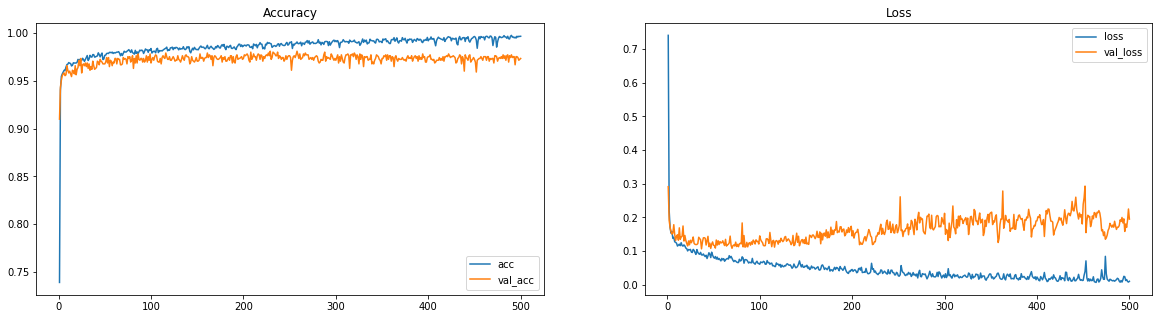

In [35]:
r = range(1, len(history_interpol.history["acc"]) + 1)

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(r, history_interpol.history["acc"], label="acc")
plt.plot(r, history_interpol.history["val_acc"], label="val_acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(r, history_interpol.history["loss"], label="loss")
plt.plot(r, history_interpol.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")

plt.show()
plt.close()

In [36]:
eval_results = np.round(model.evaluate(X_test, y_test, batch_size=16, verbose=1),2)
print("Loss:     " + str(eval_results[0]))
print("Accuracy: " + str(eval_results[1]))

1318/1318 [==============================] - 1s 473us/step
Loss:     0.23
Accuracy: 0.97


In [37]:
y_test[0]

array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)

## ROC analysis

In [38]:
counter_F_neg=0
counter_F_pos=0
for i in range(X_test.shape[0]):
    if (model.predict_classes(X_test[i:(i+1),:,:])[0]!=np.nonzero(y_test[i])[0][0]):
        if model.predict_classes(X_test[i:(i+1),:,:])[0]==0:
            counter_F_neg=counter_F_neg+1
            print("False_negative i:",i,\
              "\tPred:",model.predict_classes(X_test[i:(i+1),:,:])[0],\
              "\tActual:",np.nonzero(y_test[i])[0][0],\
              "\tProbability:",round(np.max(model.predict_proba(X_test[i:(i+1),:,:])),2),)          
        else:
            counter_F_pos=counter_F_pos+1
            print("False_positive i:",i,\
              "\tPred:",model.predict_classes(X_test[i:(i+1),:,:])[0],\
              "\tActual:",np.nonzero(y_test[i])[0][0],\
              "\tProbability:",round(np.max(model.predict_proba(X_test[i:(i+1),:,:])),2))
print("\ncounter_F_neg:",counter_F_neg) 
print("\ncounter_F_pos:",counter_F_pos) 

False_positive i: 58 	Pred: 2 	Actual: 0 	Probability: 1.0
False_negative i: 71 	Pred: 0 	Actual: 3 	Probability: 0.99
False_positive i: 106 	Pred: 1 	Actual: 0 	Probability: 1.0
False_positive i: 142 	Pred: 1 	Actual: 0 	Probability: 1.0
False_positive i: 174 	Pred: 5 	Actual: 0 	Probability: 0.97
False_positive i: 202 	Pred: 5 	Actual: 0 	Probability: 1.0
False_positive i: 245 	Pred: 1 	Actual: 0 	Probability: 1.0
False_positive i: 279 	Pred: 3 	Actual: 0 	Probability: 1.0
False_positive i: 347 	Pred: 6 	Actual: 0 	Probability: 0.8
False_negative i: 440 	Pred: 0 	Actual: 5 	Probability: 0.56
False_positive i: 481 	Pred: 5 	Actual: 0 	Probability: 0.91
False_negative i: 517 	Pred: 0 	Actual: 5 	Probability: 0.92
False_positive i: 543 	Pred: 1 	Actual: 0 	Probability: 1.0
False_positive i: 551 	Pred: 6 	Actual: 0 	Probability: 1.0
False_positive i: 625 	Pred: 1 	Actual: 0 	Probability: 0.92
False_positive i: 629 	Pred: 1 	Actual: 0 	Probability: 1.0
False_negative i: 632 	Pred: 0 	Actu

In [39]:
for i in range(X_test.shape[0]):
    if (model.predict_classes(X_test[i:(i+1),:,:])[0]==np.nonzero(y_test[i])[0][0]):
        print("Index:",i,\
              "\tPred:",model.predict_classes(X_test[i:(i+1),:,:])[0],\
              "\tActual:",np.nonzero(y_test[i])[0][0],\
              "\tProbability:",round(np.max(model.predict_proba(X_test[i:(i+1),:,:])),2))

Index: 0 	Pred: 4 	Actual: 4 	Probability: 1.0
Index: 1 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 2 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 3 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 4 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 5 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 6 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 7 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 8 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 9 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 10 	Pred: 5 	Actual: 5 	Probability: 0.88
Index: 11 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 12 	Pred: 4 	Actual: 4 	Probability: 1.0
Index: 13 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 14 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 15 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 16 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 17 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 18 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 19 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 20 	Pred: 3 	Actual: 3 	Probability: 1.0
I

Index: 181 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 182 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 183 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 184 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 185 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 186 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 187 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 188 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 189 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 190 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 191 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 192 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 193 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 194 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 195 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 196 	Pred: 4 	Actual: 4 	Probability: 0.78
Index: 197 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 198 	Pred: 4 	Actual: 4 	Probability: 1.0
Index: 199 	Pred: 4 	Actual: 4 	Probability: 1.0
Index: 200 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 201 	Pred: 2

Index: 354 	Pred: 4 	Actual: 4 	Probability: 1.0
Index: 355 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 356 	Pred: 0 	Actual: 0 	Probability: 0.91
Index: 357 	Pred: 4 	Actual: 4 	Probability: 1.0
Index: 358 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 359 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 360 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 361 	Pred: 4 	Actual: 4 	Probability: 1.0
Index: 362 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 363 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 364 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 365 	Pred: 4 	Actual: 4 	Probability: 1.0
Index: 366 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 367 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 368 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 369 	Pred: 5 	Actual: 5 	Probability: 0.99
Index: 370 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 371 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 372 	Pred: 4 	Actual: 4 	Probability: 1.0
Index: 373 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 374 	Pred: 

Index: 531 	Pred: 4 	Actual: 4 	Probability: 1.0
Index: 532 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 533 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 534 	Pred: 4 	Actual: 4 	Probability: 0.99
Index: 535 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 536 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 537 	Pred: 0 	Actual: 0 	Probability: 0.99
Index: 538 	Pred: 1 	Actual: 1 	Probability: 0.99
Index: 539 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 540 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 541 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 542 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 544 	Pred: 4 	Actual: 4 	Probability: 1.0
Index: 545 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 546 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 547 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 548 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 549 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 550 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 552 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 553 	Pred:

Index: 712 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 713 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 714 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 715 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 717 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 718 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 720 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 721 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 722 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 723 	Pred: 4 	Actual: 4 	Probability: 1.0
Index: 724 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 725 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 726 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 727 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 728 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 729 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 730 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 731 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 732 	Pred: 4 	Actual: 4 	Probability: 1.0
Index: 733 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 735 	Pred: 3 

Index: 890 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 891 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 892 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 893 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 895 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 896 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 897 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 898 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 899 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 900 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 901 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 902 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 903 	Pred: 4 	Actual: 4 	Probability: 1.0
Index: 904 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 905 	Pred: 4 	Actual: 4 	Probability: 1.0
Index: 906 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 907 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 908 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 909 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 910 	Pred: 4 	Actual: 4 	Probability: 1.0
Index: 912 	Pred: 6 

Index: 1067 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 1068 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 1069 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 1070 	Pred: 4 	Actual: 4 	Probability: 0.96
Index: 1071 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 1072 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 1073 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 1074 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 1075 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1076 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 1077 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 1078 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 1079 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 1080 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 1081 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 1082 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 1083 	Pred: 4 	Actual: 4 	Probability: 1.0
Index: 1084 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 1085 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 1086 	Pred: 1 	Actual: 1 	Probability: 1.0

Index: 1241 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 1242 	Pred: 1 	Actual: 1 	Probability: 1.0
Index: 1243 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 1244 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1245 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 1246 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 1247 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 1248 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 1249 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 1250 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 1251 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 1252 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1253 	Pred: 6 	Actual: 6 	Probability: 1.0
Index: 1254 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 1255 	Pred: 2 	Actual: 2 	Probability: 1.0
Index: 1256 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 1257 	Pred: 3 	Actual: 3 	Probability: 1.0
Index: 1258 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1259 	Pred: 5 	Actual: 5 	Probability: 1.0
Index: 1260 	Pred: 4 	Actual: 4 	Probability: 1.0


### 2.4 Save model

In [40]:
from keras.models import load_model
import h5py

In [41]:
# save model, delete current reference and re-load it from file
model.save('models/model_gesture_interpolation_' + str(new_frmlen) + '.h5')
del model
model = load_model('005_model_gesture-interpolation.h5')

In [ ]:
type(model)